# Chapter 13: Loading and Preprocessing Data with TensorFlow

### Ensure GPU Env is working correctly

In [1]:
import tensorflow as tf
import os
from tensorflow import keras

In [2]:
tf.__version__

'2.6.0'

In [3]:
keras.__version__

'2.6.0'

In [4]:
print("Num of GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num of GPUs Available:  1


### Libraries

In [5]:
import numpy as np
import pandas as pd
import os
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

## Datasets

In [6]:
# Range function in tensorflow
X = tf.range(10)
dataset = tf.data.Dataset.from_tensor_slices(X)
dataset

<TensorSliceDataset shapes: (), types: tf.int32>

In [7]:
# Can also do this
dataset = tf.data.Dataset.range(10)

In [8]:
for item in dataset:
    print(item)

tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(3, shape=(), dtype=int64)
tf.Tensor(4, shape=(), dtype=int64)
tf.Tensor(5, shape=(), dtype=int64)
tf.Tensor(6, shape=(), dtype=int64)
tf.Tensor(7, shape=(), dtype=int64)
tf.Tensor(8, shape=(), dtype=int64)
tf.Tensor(9, shape=(), dtype=int64)


In [9]:
#We repeat the dataset 3 times (30numbers) and then batch 7 of our range of 10 numbers in list
dataset = dataset.repeat(3).batch(7)
for item in dataset:
    print(item)

tf.Tensor([0 1 2 3 4 5 6], shape=(7,), dtype=int64)
tf.Tensor([7 8 9 0 1 2 3], shape=(7,), dtype=int64)
tf.Tensor([4 5 6 7 8 9 0], shape=(7,), dtype=int64)
tf.Tensor([1 2 3 4 5 6 7], shape=(7,), dtype=int64)
tf.Tensor([8 9], shape=(2,), dtype=int64)


In [10]:
# use lambda function to map functions to our dataset
dataset = dataset.map(lambda x: x * 2)

In [11]:
for item in dataset:
    print(item)

tf.Tensor([ 0  2  4  6  8 10 12], shape=(7,), dtype=int64)
tf.Tensor([14 16 18  0  2  4  6], shape=(7,), dtype=int64)
tf.Tensor([ 8 10 12 14 16 18  0], shape=(7,), dtype=int64)
tf.Tensor([ 2  4  6  8 10 12 14], shape=(7,), dtype=int64)
tf.Tensor([16 18], shape=(2,), dtype=int64)


In [12]:
# now to unbatch or single out the elements in the array to get single elements for us to take
dataset = dataset.unbatch()
dataset = dataset.filter(lambda x: x < 10) # 10 items to keep from batch

In [13]:
for item in dataset.take(3):
    print(item)

tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(4, shape=(), dtype=int64)


In [14]:
# Now we could shuffle our digits and repeat them again three times with a batch of 7 again
dataset = tf.data.Dataset.range(10).repeat(3)
dataset = dataset.shuffle(buffer_size=3).batch(7)
for item in dataset:
    print(item)

tf.Tensor([2 3 0 4 5 1 8], shape=(7,), dtype=int64)
tf.Tensor([6 0 9 1 3 2 7], shape=(7,), dtype=int64)
tf.Tensor([4 6 7 5 8 0 2], shape=(7,), dtype=int64)
tf.Tensor([3 1 9 5 7 8 6], shape=(7,), dtype=int64)
tf.Tensor([9 4], shape=(2,), dtype=int64)


## Working with a dataset and save to multiple CSV files

Let's start by loading and preparing the California housing dataset. We first load it, then split it into a training set, a validation set and a test set, and finally we scale it:

In [15]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing_df = fetch_california_housing()
X_train_ds, X_test, y_train_ds, y_test = train_test_split(housing_df.data, 
                                                         housing_df.target.reshape(-1, 1),)
X_train, X_val, y_train, y_val = train_test_split(X_train_ds, y_train_ds)

scaler = StandardScaler()
scaler.fit(X_train)
X_mean = scaler.mean_
X_std = scaler.scale_

If we're dealing with a very large dataset that cannot fit in memory, it is best to split it into many differenty files then have TensorFlow read the files in parallel. Let's do that in a function below:

In [16]:
def save_to_multiple_csv_files(data, name_prefix, header=None, n_parts=10):
    housing_dir = os.path.join("datasets", "housing")
    os.makedirs(housing_dir, exist_ok=True)
    path_format = os.path.join(housing_dir, "my_{}_{:02d}.csv")
    
    filepaths = []
    m = len(data)
    for files, rows in enumerate(np.array_split(np.arange(m), n_parts)):
        csv = path_format.format(name_prefix, files)
        filepaths.append(csv)
        with open(csv, "wt", encoding="utf-8") as w:
            if header is not None:
                w.write(header)
                w.write("\n")
            for row in rows:
                w.write(",".join([repr(col) for col in data[row]]))
                w.write("\n")
    return filepaths

In [17]:
training_data = np.c_[X_train, y_train]
validation_data = np.c_[X_val, y_val]
testing_data = np.c_[X_test, y_test]
column_headers = housing_df.feature_names + ["MedianHouseValue"]
header = ",".join(column_headers)

training_filepaths = save_to_multiple_csv_files(training_data, "train", header, n_parts=20)
validation_filepaths = save_to_multiple_csv_files(validation_data, "valid", header, n_parts=10)
testing_filepaths = save_to_multiple_csv_files(testing_data, "test", header, n_parts=10)

In [18]:
trainingdf_1 = pd.read_csv(training_filepaths[0])

In [19]:
trainingdf_1.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedianHouseValue
0,1.8438,35.0,4.623853,1.155963,323.0,2.963303,37.74,-122.18,0.90500
1,3.1630,40.0,3.875000,0.966912,1922.0,3.533088,33.98,-118.34,1.37800
2,15.0001,34.0,8.114173,1.023622,825.0,3.248031,34.19,-118.19,5.00001
3,2.1875,28.0,1.972906,0.982759,936.0,2.305419,34.05,-118.45,1.81300
4,3.1729,45.0,5.219643,1.078571,1903.0,3.398214,34.14,-118.08,2.18700


In [20]:
# Could also open in text mode if needed
with open(training_filepaths[0]) as f:
    for i in range(5):
        print(f.readline(), end="")

MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedianHouseValue
1.8438,35.0,4.623853211009174,1.1559633027522935,323.0,2.963302752293578,37.74,-122.18,0.905
3.163,40.0,3.875,0.9669117647058824,1922.0,3.5330882352941178,33.98,-118.34,1.378
15.0001,34.0,8.114173228346457,1.0236220472440944,825.0,3.248031496062992,34.19,-118.19,5.00001
2.1875,28.0,1.9729064039408868,0.9827586206896551,936.0,2.3054187192118225,34.05,-118.45,1.813


In [21]:
training_filepaths

['datasets\\housing\\my_train_00.csv',
 'datasets\\housing\\my_train_01.csv',
 'datasets\\housing\\my_train_02.csv',
 'datasets\\housing\\my_train_03.csv',
 'datasets\\housing\\my_train_04.csv',
 'datasets\\housing\\my_train_05.csv',
 'datasets\\housing\\my_train_06.csv',
 'datasets\\housing\\my_train_07.csv',
 'datasets\\housing\\my_train_08.csv',
 'datasets\\housing\\my_train_09.csv',
 'datasets\\housing\\my_train_10.csv',
 'datasets\\housing\\my_train_11.csv',
 'datasets\\housing\\my_train_12.csv',
 'datasets\\housing\\my_train_13.csv',
 'datasets\\housing\\my_train_14.csv',
 'datasets\\housing\\my_train_15.csv',
 'datasets\\housing\\my_train_16.csv',
 'datasets\\housing\\my_train_17.csv',
 'datasets\\housing\\my_train_18.csv',
 'datasets\\housing\\my_train_19.csv']

### Build an input pipeline in TF

In [22]:
dataset_fpth = tf.data.Dataset.list_files(training_filepaths)

In [23]:
for filepath in dataset_fpth:
    print(filepath)

tf.Tensor(b'datasets\\housing\\my_train_10.csv', shape=(), dtype=string)
tf.Tensor(b'datasets\\housing\\my_train_18.csv', shape=(), dtype=string)
tf.Tensor(b'datasets\\housing\\my_train_08.csv', shape=(), dtype=string)
tf.Tensor(b'datasets\\housing\\my_train_15.csv', shape=(), dtype=string)
tf.Tensor(b'datasets\\housing\\my_train_03.csv', shape=(), dtype=string)
tf.Tensor(b'datasets\\housing\\my_train_12.csv', shape=(), dtype=string)
tf.Tensor(b'datasets\\housing\\my_train_04.csv', shape=(), dtype=string)
tf.Tensor(b'datasets\\housing\\my_train_00.csv', shape=(), dtype=string)
tf.Tensor(b'datasets\\housing\\my_train_09.csv', shape=(), dtype=string)
tf.Tensor(b'datasets\\housing\\my_train_01.csv', shape=(), dtype=string)
tf.Tensor(b'datasets\\housing\\my_train_11.csv', shape=(), dtype=string)
tf.Tensor(b'datasets\\housing\\my_train_13.csv', shape=(), dtype=string)
tf.Tensor(b'datasets\\housing\\my_train_05.csv', shape=(), dtype=string)
tf.Tensor(b'datasets\\housing\\my_train_02.csv', sh

In [24]:
# setup 5 different csv line readers to interleave values together
n_readers = 5
dataset = dataset_fpth.interleave(
            lambda filepath: tf.data.TextLineDataset(filepath).skip(1),
            cycle_length=n_readers)

In [25]:
for line in dataset.take(10):
    print(line.numpy())

b'4.5217,23.0,5.1867612293144205,1.0212765957446808,2526.0,2.9858156028368796,33.84,-117.84,2.194'
b'4.6875,20.0,4.348623853211009,1.0458715596330275,1069.0,2.4518348623853212,37.41,-122.08,2.889'
b'5.37,26.0,6.127579737335835,0.9212007504690432,1222.0,2.292682926829268,37.76,-122.13,2.754'
b'2.9781,31.0,3.642737896494157,1.0517529215358932,1069.0,1.7846410684474123,32.8,-117.25,2.125'
b'10.3345,5.0,8.74031007751938,1.0426356589147288,876.0,3.395348837209302,37.76,-121.93,4.614'
b'1.4167,20.0,4.066666666666666,1.1238095238095238,402.0,3.8285714285714287,33.96,-118.18,1.375'
b'2.0804,42.0,4.294117647058823,1.1176470588235294,1206.0,2.026890756302521,37.84,-122.26,2.267'
b'5.6441,18.0,6.089593383873191,1.0523776705720194,3946.0,2.7195037904893176,33.91,-117.94,3.13'
b'1.8281,44.0,3.78,0.8933333333333333,565.0,3.7666666666666666,34.11,-117.27,0.629'
b'7.5443,9.0,6.723404255319149,0.9957446808510638,1675.0,3.5638297872340425,37.33,-121.77,3.484'


Judging by the quotations, it seems that we are getting strings back... Let's look at the decode_csv function in TF to see if it can give us some insight:

In [26]:
records = [0, np.nan, tf.constant(np.nan, dtype=tf.float64), "Hi There~", tf.constant([])]

In [27]:
decoding_csv = tf.io.decode_csv('1,2,3,4,5', record_defaults=records)
decoding_csv

[<tf.Tensor: shape=(), dtype=int32, numpy=1>,
 <tf.Tensor: shape=(), dtype=float32, numpy=2.0>,
 <tf.Tensor: shape=(), dtype=float64, numpy=3.0>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'4'>,
 <tf.Tensor: shape=(), dtype=float32, numpy=5.0>]

let's now see the default values with nothing except the last value in that string call (because it is the default necessary):

In [28]:
decoding_csv = tf.io.decode_csv(",,,,8", record_defaults=records)
decoding_csv

[<tf.Tensor: shape=(), dtype=int32, numpy=0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=nan>,
 <tf.Tensor: shape=(), dtype=float64, numpy=nan>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'Hi There~'>,
 <tf.Tensor: shape=(), dtype=float32, numpy=8.0>]

Otherwise we get an error:

In [29]:
try:
    decoding_csv = tf.io.decode_csv(',,,,', record_defaults=records)
except tf.errors.InvalidArgumentError as ex:
    print(ex)

Field 4 is required but missing in record 0! [Op:DecodeCSV]


Now it is time to fix and preprocess our dataset:

In [30]:
n_inputs = 8 # X_train.shape[-1]

@tf.function
def preprocess(line):
    defs = [0.] * n_inputs + [tf.constant([], dtype=tf.float32)]
    fields = tf.io.decode_csv(line, record_defaults=defs)
    x = tf.stack(fields[:-1])
    y = tf.stack(fields[-1:])
    return (x - X_mean) / X_std, y

In [31]:
#first line from output
preprocess(b'4.5217,23.0,5.1867612293144205,1.0212765957446808,2526.0,2.9858156028368796,33.84,-117.84,2.194')

(<tf.Tensor: shape=(8,), dtype=float32, numpy=
 array([ 0.33967397, -0.44173327, -0.10424154, -0.16569561,  1.0373163 ,
        -0.00863913, -0.83841485,  0.8620488 ], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([2.194], dtype=float32)>)

In [32]:
# Putting it all together
def csv_reader_dataset(filepaths, repeat=1, n_readers=5, n_read_threads=None, shuffle_buffer_size=10000,
                       n_parse_threads=5, batch_size=32):
    dataset = tf.data.Dataset.list_files(filepaths).repeat(repeat)
    dataset = dataset.interleave(
        lambda filepath: tf.data.TextLineDataset(filepath).skip(1),
        cycle_length=n_readers, num_parallel_calls=n_read_threads)
    dataset = dataset.shuffle(shuffle_buffer_size)
    dataset = dataset.map(preprocess, num_parallel_calls=n_parse_threads)
    dataset = dataset.batch(batch_size)
    return dataset.prefetch(1)


In [33]:
train_set = csv_reader_dataset(training_filepaths, batch_size=3)
for X_batch, y_batch in train_set.take(2):
    print("X =", X_batch)
    print("y =", y_batch)
    print()

X = tf.Tensor(
[[-0.78667635 -1.0738989  -0.61369044  0.17542437  1.18327     0.0029808
  -0.6845263   0.59804225]
 [-0.33520082 -0.28369185 -0.80488735  0.39220905 -0.92887485 -0.09408078
   0.23414785 -1.0208465 ]
 [ 0.49696267 -0.9948782  -0.12979206 -0.23257889 -0.08661993 -0.04140528
  -0.8943742   0.8819702 ]], shape=(3, 8), dtype=float32)
y = tf.Tensor(
[[1.854]
 [4.5  ]
 [2.014]], shape=(3, 1), dtype=float32)

X = tf.Tensor(
[[ 0.2672572  -0.20467116 -0.28708923  0.21515547 -0.29021135 -0.08503555
  -0.68918884  0.5532133 ]
 [ 0.9736631  -1.9431266   0.53972346  0.6172938  -0.26139247 -0.077267
  -1.0016303   0.9218207 ]
 [-1.3168225   0.90161866 -0.3512487  -0.18556666 -0.68344957 -0.03069402
   1.3859879  -0.92620254]], shape=(3, 8), dtype=float32)
y = tf.Tensor(
[[2.991  ]
 [5.00001]
 [0.652  ]], shape=(3, 1), dtype=float32)



## Create and Train Model from Pipeline

In [34]:
train_set = csv_reader_dataset(training_filepaths, repeat=None)
val_set = csv_reader_dataset(validation_filepaths)
test_set = csv_reader_dataset(testing_filepaths)

In [35]:
model = keras.models.Sequential([keras.layers.Dense(30, activation="relu", input_shape=X_train.shape[1:]),
                                keras.layers.Dense(15, activation="relu"),
                                keras.layers.Dense(1),
])

In [36]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=10e-3))

In [37]:
batch_size = 32
model.fit(train_set, steps_per_epoch=len(X_train) // batch_size, epochs=10, validation_data=val_set)

Epoch 1/10
362/362 [==============================] - 6s 5ms/step - loss: 1.0483 - val_loss: 0.5649
Epoch 2/10
362/362 [==============================] - 1s 4ms/step - loss: 0.7604 - val_loss: 0.4820
Epoch 3/10
362/362 [==============================] - 1s 4ms/step - loss: 0.4254 - val_loss: 0.4713
Epoch 4/10
362/362 [==============================] - 1s 4ms/step - loss: 0.4113 - val_loss: 0.4312
Epoch 5/10
362/362 [==============================] - 1s 4ms/step - loss: 0.3916 - val_loss: 0.4234
Epoch 6/10
362/362 [==============================] - 1s 4ms/step - loss: 0.3855 - val_loss: 0.4191
Epoch 7/10
362/362 [==============================] - 1s 4ms/step - loss: 0.3692 - val_loss: 0.3984
Epoch 8/10
362/362 [==============================] - 1s 4ms/step - loss: 0.3637 - val_loss: 0.3942
Epoch 9/10
362/362 [==============================] - 1s 4ms/step - loss: 0.3562 - val_loss: 0.3925
Epoch 10/10
362/362 [==============================] - 1s 4ms/step - loss: 0.3611 - val_loss: 0.3746

In [38]:
model.evaluate(test_set, steps=len(X_test) // batch_size)

161/161 [==============================] - 0s 2ms/step - loss: 0.3788


0.37883707880973816

In [39]:
# now to predict
new_set = test_set.map(lambda X, y: X) # we could instead just pass test_set, Keras would ignore the labels
X_new = X_test
model.predict(new_set, steps=len(X_new) // batch_size)

array([[3.9843297],
       [0.8679904],
       [3.6915605],
       ...,
       [2.1079144],
       [2.3962379],
       [2.230005 ]], dtype=float32)

## Functions to Train Model Standalone

In [40]:
optimizer = keras.optimizers.Nadam(learning_rate=0.01)
loss_fn = keras.losses.mean_squared_error

n_epochs = 5
batch_size = 32
n_steps_per_epoch = len(X_train) // batch_size
total_steps = n_epochs * n_steps_per_epoch
global_step = 0
for X_batch, y_batch in train_set.take(total_steps):
    global_step += 1
    print("\rGlobal step {}/{}".format(global_step, total_steps), end="")
    with tf.GradientTape() as tape:
        y_pred = model(X_batch)
        main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
        loss = tf.add_n([main_loss] + model.losses)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

Global step 1810/1810

In [41]:
optimizer = keras.optimizers.Nadam(learning_rate=0.01)
loss_fn = keras.losses.mean_squared_error

@tf.function
def train(model, n_epochs, batch_size=32,
          n_readers=5, n_read_threads=5, shuffle_buffer_size=10000, n_parse_threads=5):
    train_set = csv_reader_dataset(training_filepaths, repeat=n_epochs, n_readers=n_readers,
                       n_read_threads=n_read_threads, shuffle_buffer_size=shuffle_buffer_size,
                       n_parse_threads=n_parse_threads, batch_size=batch_size)
    n_steps_per_epoch = len(X_train) // batch_size
    total_steps = n_epochs * n_steps_per_epoch
    global_step = 0
    for X_batch, y_batch in train_set.take(total_steps):
        global_step += 1
        if tf.equal(global_step % 100, 0):
            tf.print("\rGlobal step", global_step, "/", total_steps)
        with tf.GradientTape() as tape:
            y_pred = model(X_batch)
            main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
            loss = tf.add_n([main_loss] + model.losses)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

train(model, 5)

Global step 100 / 1810
Global step 200 / 1810
Global step 300 / 1810
Global step 400 / 1810
Global step 500 / 1810
Global step 600 / 1810
Global step 700 / 1810
Global step 800 / 1810
Global step 900 / 1810
Global step 1000 / 1810
Global step 1100 / 1810
Global step 1200 / 1810
Global step 1300 / 1810
Global step 1400 / 1810
Global step 1500 / 1810
Global step 1600 / 1810
Global step 1700 / 1810
Global step 1800 / 1810


## Methods in Dataset Class

In [42]:
for m in dir(tf.data.Dataset):
    if not (m.startswith("_") or m.endswith("_")):
        func = getattr(tf.data.Dataset, m)
        if hasattr(func, "__doc__"):
            print("● {:21s}{}".format(m + "()", func.__doc__.split("\n")[0]))

● apply()              Applies a transformation function to this dataset.
● as_numpy_iterator()  Returns an iterator which converts all elements of the dataset to numpy.
● batch()              Combines consecutive elements of this dataset into batches.
● bucket_by_sequence_length()A transformation that buckets elements in a `Dataset` by length.
● cache()              Caches the elements in this dataset.
● cardinality()        Returns the cardinality of the dataset, if known.
● concatenate()        Creates a `Dataset` by concatenating the given dataset with this dataset.
● element_spec()       The type specification of an element of this dataset.
● enumerate()          Enumerates the elements of this dataset.
● filter()             Filters this dataset according to `predicate`.
● flat_map()           Maps `map_func` across this dataset and flattens the result.
● from_generator()     Creates a `Dataset` whose elements are generated by `generator`. (deprecated arguments)
● from_tensor_sli

## TFRecord Binary Format

TFReocrds is a list of binary records you can create using `td.io.TFRecordWriter`:

In [43]:
with tf.io.TFRecordWriter("my_data.tfrecord") as f:
    f.write(b"This is the first record")
    f.write(b"And this is the second record")

In [44]:
# read the records
filepaths = ["my_data.tfrecord"]
dataset = tf.data.TFRecordDataset(filepaths)
for item in dataset:
    print(item)

tf.Tensor(b'This is the first record', shape=(), dtype=string)
tf.Tensor(b'And this is the second record', shape=(), dtype=string)


You can read multiple TFRecord files with just one `TFRecordDataset`. By default it will read them one at a time, but if you set `num_parallel_reads=3`, it will read 3 at a time in parallel and interleave their records:

In [45]:
filepaths = ["my_test_{}.tfrecord".format(i) for i in range(5)]
for i, filepath in enumerate(filepaths):
    with tf.io.TFRecordWriter(filepath) as f:
        for j in range(3):
            f.write("File {} record {}".format(i, j).encode("utf-8"))

dataset = tf.data.TFRecordDataset(filepaths, num_parallel_reads=3)
for item in dataset:
    print(item)

tf.Tensor(b'File 0 record 0', shape=(), dtype=string)
tf.Tensor(b'File 1 record 0', shape=(), dtype=string)
tf.Tensor(b'File 2 record 0', shape=(), dtype=string)
tf.Tensor(b'File 0 record 1', shape=(), dtype=string)
tf.Tensor(b'File 1 record 1', shape=(), dtype=string)
tf.Tensor(b'File 2 record 1', shape=(), dtype=string)
tf.Tensor(b'File 0 record 2', shape=(), dtype=string)
tf.Tensor(b'File 1 record 2', shape=(), dtype=string)
tf.Tensor(b'File 2 record 2', shape=(), dtype=string)
tf.Tensor(b'File 3 record 0', shape=(), dtype=string)
tf.Tensor(b'File 4 record 0', shape=(), dtype=string)
tf.Tensor(b'File 3 record 1', shape=(), dtype=string)
tf.Tensor(b'File 4 record 1', shape=(), dtype=string)
tf.Tensor(b'File 3 record 2', shape=(), dtype=string)
tf.Tensor(b'File 4 record 2', shape=(), dtype=string)


In [46]:
# Can also compress our records either using the ZLIB algorithm or GZIP algorithm method
options = tf.io.TFRecordOptions(compression_type="GZIP")
with tf.io.TFRecordWriter("my_compressed.tfrecord", options) as f:
    f.write(b"This is the first record")
    f.write(b"And this is the second record")

In [47]:
dataset = tf.data.TFRecordDataset(["my_compressed.tfrecord"],
                                  compression_type="GZIP")
for item in dataset:
    print(item)

tf.Tensor(b'This is the first record', shape=(), dtype=string)
tf.Tensor(b'And this is the second record', shape=(), dtype=string)


## TensorFlow Protobufs

Example using the definition for the tf.train.Example protobuf:

```proto
syntax = "proto3";

message BytesList { repeated bytes value = 1; }
message FloatList { repeated float value = 1 [packed = true]; }
message Int64List { repeated int64 value = 1 [packed = true]; }
message Feature {
    oneof kind {
        BytesList bytes_list = 1;
        FloatList float_list = 2;
        Int64List int64_list = 3;
    }
};
message Features { map<string, Feature> feature = 1; };
message Example { Features features = 1; };
```

In [48]:
# Example in TensorFlow
from tensorflow.train import BytesList, FloatList, Int64List
from tensorflow.train import Feature, Features, Example
BytesList = tf.train.BytesList
FloatList = tf.train.FloatList
Int64List = tf.train.Int64List
Feature = tf.train.Feature
Features = tf.train.Features
Example = tf.train.Example

person_example = Example(
    features=Features(
        feature={
            "name": Feature(bytes_list=BytesList(value=[b"Alice"])),
            "id": Feature(int64_list=Int64List(value=[123])),
            "emails": Feature(bytes_list=BytesList(value=[b"a@b.com", b"c@d.com"]))
        }))

with tf.io.TFRecordWriter("my_contacts.tfrecord") as f:
    f.write(person_example.SerializeToString())

In [49]:
feature_description = {
    "name": tf.io.FixedLenFeature([], tf.string, default_value=""),
    "id": tf.io.FixedLenFeature([], tf.int64, default_value=0),
    "emails": tf.io.VarLenFeature(tf.string),
}
for serialized_example in tf.data.TFRecordDataset(["my_contacts.tfrecord"]):
    parsed_example = tf.io.parse_single_example(serialized_example,
                                                feature_description)

In [50]:
parsed_example

{'emails': <tensorflow.python.framework.sparse_tensor.SparseTensor at 0x26ec8dfef10>,
 'id': <tf.Tensor: shape=(), dtype=int64, numpy=123>,
 'name': <tf.Tensor: shape=(), dtype=string, numpy=b'Alice'>}

In [51]:
parsed_example["emails"].values[0]

<tf.Tensor: shape=(), dtype=string, numpy=b'a@b.com'>

In [52]:
# converts SparseTensor to DenseTensor
tf.sparse.to_dense(parsed_example["emails"], default_value=b"")

<tf.Tensor: shape=(2,), dtype=string, numpy=array([b'a@b.com', b'c@d.com'], dtype=object)>

In [53]:
# new example 
parsed_example["emails"].values

<tf.Tensor: shape=(2,), dtype=string, numpy=array([b'a@b.com', b'c@d.com'], dtype=object)>

## Transforming images to tensors and then back again

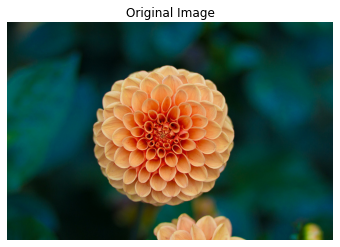

In [54]:
from sklearn.datasets import load_sample_images

img = load_sample_images()["images"][1]
plt.imshow(img)
plt.axis("off")
plt.title("Original Image")
plt.show()

In [55]:
data = tf.io.encode_jpeg(img) # function to encode it to 3-D unit8 Tensor
example_with_image = Example(features=Features(feature={
    "image": Feature(bytes_list=BytesList(value=[data.numpy()]))}))
serialized_example = example_with_image.SerializeToString()

In [56]:
feature_description = { "image": tf.io.VarLenFeature(tf.string) }
example_with_image = tf.io.parse_single_example(serialized_example, feature_description)
decoded_img = tf.io.decode_jpeg(example_with_image["image"].values[0])

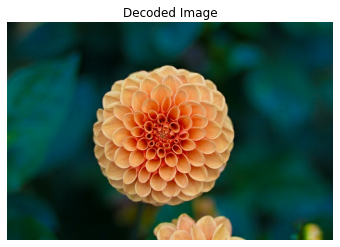

In [57]:
plt.imshow(decoded_img)
plt.title("Decoded Image")
plt.axis("off")
plt.show()

We could also use the `tf.io.decode_image` function in the same way. This function supports the following file types: BMP,GIF, JPEG and PNG:

In [58]:
decoded_img = tf.io.decode_image(example_with_image["image"].values[0])

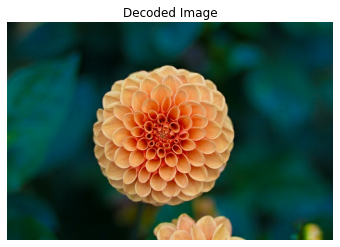

In [59]:
plt.imshow(decoded_img)
plt.title("Decoded Image")
plt.axis("off")
plt.show()

### Being able to put tensors and sparse tensors in TFRecords

Tensors can be serialized and parsed easily using `tf.io.serialize_tensor()` and `tf.io.parse_tensor()`:

In [60]:
t = tf.constant([[0., 1.], [2., 3.], [4., 5.]])
s = tf.io.serialize_tensor(t)
s

<tf.Tensor: shape=(), dtype=string, numpy=b'\x08\x01\x12\x08\x12\x02\x08\x03\x12\x02\x08\x02"\x18\x00\x00\x00\x00\x00\x00\x80?\x00\x00\x00@\x00\x00@@\x00\x00\x80@\x00\x00\xa0@'>

In [61]:
tf.io.parse_tensor(s, out_type=tf.float32)

<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[0., 1.],
       [2., 3.],
       [4., 5.]], dtype=float32)>

In [62]:
serialized_sparse = tf.io.serialize_sparse(parsed_example["emails"])
serialized_sparse

<tf.Tensor: shape=(3,), dtype=string, numpy=
array([b'\x08\t\x12\x08\x12\x02\x08\x02\x12\x02\x08\x01"\x10\x00\x00\x00\x00\x00\x00\x00\x00\x01\x00\x00\x00\x00\x00\x00\x00',
       b'\x08\x07\x12\x04\x12\x02\x08\x02"\x10\x07\x07a@b.comc@d.com',
       b'\x08\t\x12\x04\x12\x02\x08\x01"\x08\x02\x00\x00\x00\x00\x00\x00\x00'],
      dtype=object)>

In [63]:
BytesList(value=serialized_sparse.numpy())

value: "\010\t\022\010\022\002\010\002\022\002\010\001\"\020\000\000\000\000\000\000\000\000\001\000\000\000\000\000\000\000"
value: "\010\007\022\004\022\002\010\002\"\020\007\007a@b.comc@d.com"
value: "\010\t\022\004\022\002\010\001\"\010\002\000\000\000\000\000\000\000"

In [64]:
dataset = tf.data.TFRecordDataset(["my_contacts.tfrecord"]).batch(10)
for serialized_examples in dataset:
    parsed_examples = tf.io.parse_example(serialized_examples,
                                          feature_description)

In [65]:
parsed_examples

{'image': <tensorflow.python.framework.sparse_tensor.SparseTensor at 0x26ec8d73e20>}

## Handling sequential data using `SequenceExample`

```proto
    syntax = "proto3";

    message FeatureList { repeated Feature feature = 1; };
    message FeatureLists { map<string, FeatureList> feature_list = 1; };
    message SequenceExample {
      Features context = 1;
      FeatureLists feature_lists = 2;
    };
```

In [66]:
# Same example from before but with the SequenceExample
from tensorflow.train import FeatureList, FeatureLists, SequenceExample
FeatureList = tf.train.FeatureList
FeatureLists = tf.train.FeatureLists
SequenceExample = tf.train.SequenceExample

context = Features(feature={
    "author_id": Feature(int64_list=Int64List(value=[123])),
    "title": Feature(bytes_list=BytesList(value=[b"A", b"desert", b"place", b"."])),
    "pub_date": Feature(int64_list=Int64List(value=[1623, 12, 25]))
})

content = [["When", "shall", "we", "three", "meet", "again", "?"],
           ["In", "thunder", ",", "lightning", ",", "or", "in", "rain", "?"]]
comments = [["When", "the", "hurlyburly", "'s", "done", "."],
            ["When", "the", "battle", "'s", "lost", "and", "won", "."]]

def words_to_feature(words):
    return Feature(bytes_list=BytesList(value=[word.encode("utf-8")
                                               for word in words]))

content_features = [words_to_feature(sentence) for sentence in content]
comments_features = [words_to_feature(comment) for comment in comments]
            
sequence_example = SequenceExample(
    context=context,
    feature_lists=FeatureLists(feature_list={
        "content": FeatureList(feature=content_features),
        "comments": FeatureList(feature=comments_features)
    }))

In [67]:
sequence_example

context {
  feature {
    key: "author_id"
    value {
      int64_list {
        value: 123
      }
    }
  }
  feature {
    key: "pub_date"
    value {
      int64_list {
        value: 1623
        value: 12
        value: 25
      }
    }
  }
  feature {
    key: "title"
    value {
      bytes_list {
        value: "A"
        value: "desert"
        value: "place"
        value: "."
      }
    }
  }
}
feature_lists {
  feature_list {
    key: "comments"
    value {
      feature {
        bytes_list {
          value: "When"
          value: "the"
          value: "hurlyburly"
          value: "\'s"
          value: "done"
          value: "."
        }
      }
      feature {
        bytes_list {
          value: "When"
          value: "the"
          value: "battle"
          value: "\'s"
          value: "lost"
          value: "and"
          value: "won"
          value: "."
        }
      }
    }
  }
  feature_list {
    key: "content"
    value {
      feature {
      

In [68]:
serialized_sequence_example = sequence_example.SerializeToString()
serialized_sequence_example

b"\nL\n\x12\n\tauthor_id\x12\x05\x1a\x03\n\x01{\n \n\x05title\x12\x17\n\x15\n\x01A\n\x06desert\n\x05place\n\x01.\n\x14\n\x08pub_date\x12\x08\x1a\x06\n\x04\xd7\x0c\x0c\x19\x12\xd0\x01\nj\n\x07content\x12_\n*\n(\n\x04When\n\x05shall\n\x02we\n\x05three\n\x04meet\n\x05again\n\x01?\n1\n/\n\x02In\n\x07thunder\n\x01,\n\tlightning\n\x01,\n\x02or\n\x02in\n\x04rain\n\x01?\nb\n\x08comments\x12V\n&\n$\n\x04When\n\x03the\n\nhurlyburly\n\x02's\n\x04done\n\x01.\n,\n*\n\x04When\n\x03the\n\x06battle\n\x02's\n\x04lost\n\x03and\n\x03won\n\x01."

In [69]:
context_feature_descriptions = {
    "author_id": tf.io.FixedLenFeature([], tf.int64, default_value=0),
    "title": tf.io.VarLenFeature(tf.string),
    "pub_date": tf.io.FixedLenFeature([3], tf.int64, default_value=[0, 0, 0]),
}
sequence_feature_descriptions = {
    "content": tf.io.VarLenFeature(tf.string),
    "comments": tf.io.VarLenFeature(tf.string),
}
parsed_context, parsed_feature_lists = tf.io.parse_single_sequence_example(
    serialized_sequence_example, context_feature_descriptions,
    sequence_feature_descriptions)

In [70]:
parsed_context

{'title': <tensorflow.python.framework.sparse_tensor.SparseTensor at 0x26ed01e5ee0>,
 'author_id': <tf.Tensor: shape=(), dtype=int64, numpy=123>,
 'pub_date': <tf.Tensor: shape=(3,), dtype=int64, numpy=array([1623,   12,   25], dtype=int64)>}

In [71]:
parsed_context["title"].values

<tf.Tensor: shape=(4,), dtype=string, numpy=array([b'A', b'desert', b'place', b'.'], dtype=object)>

In [72]:
parsed_feature_lists

{'comments': <tensorflow.python.framework.sparse_tensor.SparseTensor at 0x26ece89ed00>,
 'content': <tensorflow.python.framework.sparse_tensor.SparseTensor at 0x26ed01fd790>}

In [73]:
print(tf.RaggedTensor.from_sparse(parsed_feature_lists["content"]))

<tf.RaggedTensor [[b'When', b'shall', b'we', b'three', b'meet', b'again', b'?'], [b'In', b'thunder', b',', b'lightning', b',', b'or', b'in', b'rain', b'?']]>


## Using the housing dataset with the TF features API

We will use the variant of the California housing dataset from Chapter 2, since it contains categorical features and missing values:

In [74]:
import os
import tarfile
import urllib.request

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    os.makedirs(housing_path, exist_ok=True)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [75]:
fetch_housing_data()

In [76]:
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [77]:
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [78]:
housing_median_age = tf.feature_column.numeric_column("housing_median_age")

In [79]:
age_mean, age_std = X_mean[1], X_std[1]  # The median age is column in 1
housing_median_age = tf.feature_column.numeric_column(
    "housing_median_age", normalizer_fn=lambda x: (x - age_mean) / age_std)

In [80]:
median_income = tf.feature_column.numeric_column("median_income")
bucketized_income = tf.feature_column.bucketized_column(
    median_income, boundaries=[1.5, 3., 4.5, 6.])

In [81]:
bucketized_income

BucketizedColumn(source_column=NumericColumn(key='median_income', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), boundaries=(1.5, 3.0, 4.5, 6.0))

In [82]:
ocean_prox_vocab = ['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN']
ocean_proximity = tf.feature_column.categorical_column_with_vocabulary_list(
    "ocean_proximity", ocean_prox_vocab)

In [83]:
ocean_proximity

VocabularyListCategoricalColumn(key='ocean_proximity', vocabulary_list=('<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'), dtype=tf.string, default_value=-1, num_oov_buckets=0)

In [84]:
# Just an example, it's not used later on
city_hash = tf.feature_column.categorical_column_with_hash_bucket(
    "city", hash_bucket_size=1000)
city_hash

HashedCategoricalColumn(key='city', hash_bucket_size=1000, dtype=tf.string)

In [85]:
bucketized_age = tf.feature_column.bucketized_column(
    housing_median_age, boundaries=[-1., -0.5, 0., 0.5, 1.]) # age was scaled
age_and_ocean_proximity = tf.feature_column.crossed_column(
    [bucketized_age, ocean_proximity], hash_bucket_size=100)

In [86]:
latitude = tf.feature_column.numeric_column("latitude")
longitude = tf.feature_column.numeric_column("longitude")
bucketized_latitude = tf.feature_column.bucketized_column(
    latitude, boundaries=list(np.linspace(32., 42., 20 - 1)))
bucketized_longitude = tf.feature_column.bucketized_column(
    longitude, boundaries=list(np.linspace(-125., -114., 20 - 1)))
location = tf.feature_column.crossed_column(
    [bucketized_latitude, bucketized_longitude], hash_bucket_size=1000)

In [87]:
ocean_proximity_one_hot = tf.feature_column.indicator_column(ocean_proximity)
ocean_proximity_embed = tf.feature_column.embedding_column(ocean_proximity,
                                                           dimension=2)

As you can see from the above example. There a lot of similar features that are available in the TensorFlow API that we created ourselves when working on this problem back in chapter 2. Neat stuff to say the least.

## Using feature columns for parsing

In [88]:
median_house_value = tf.feature_column.numeric_column("median_house_value")

In [89]:
columns = [housing_median_age, median_house_value]
feature_descriptions = tf.feature_column.make_parse_example_spec(columns)
feature_descriptions

{'housing_median_age': FixedLenFeature(shape=(1,), dtype=tf.float32, default_value=None),
 'median_house_value': FixedLenFeature(shape=(1,), dtype=tf.float32, default_value=None)}

In [90]:
with tf.io.TFRecordWriter("my_data_with_features.tfrecords") as f:
    for x, y in zip(X_train[:, 1:2], y_train):
        example = Example(features=Features(feature={
            "housing_median_age": Feature(float_list=FloatList(value = x)),
            "median_house_value": Feature(float_list=FloatList(value=y))
        }))
        f.write(example.SerializeToString())

In [91]:
def parse_examples(serialized_examples):
    examples = tf.io.parse_example(serialized_examples, feature_descriptions)
    targets = examples.pop("median_house_value") # separate the targets
    return examples, targets

batch_size = 32
dataset = tf.data.TFRecordDataset(["my_data_with_features.tfrecords"])
dataset = dataset.repeat().shuffle(10000).batch(batch_size).map(parse_examples)

In [92]:
columns_without_target = columns[:-1]
model = keras.models.Sequential([
    keras.layers.DenseFeatures(feature_columns=columns_without_target),
    keras.layers.Dense(1)
])
model.compile(loss="mse",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])
model.fit(dataset, steps_per_epoch=len(X_train) // batch_size, epochs=5)

Epoch 1/5
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
362/362 [==============================] - 1s 3ms/step - loss: 3.6124 - accuracy: 0.0013
Epoch 2/5
362/362 [==============================] - 1s 3ms/step - loss: 1.9000 - accuracy: 0.0024
Epoch 3/5
362/362 [==============================] - 1s 3ms/step - loss: 1.4457 - accuracy: 0.0031
Epoch 4/5
362/362 [==============================] - 1s 3ms/step - loss: 1.3280 - accuracy: 0.0025
Epoch 5/5
362/362 [==============================] - 1s 3ms/step - loss: 1.2958 - accuracy: 0.0029


In [93]:
some_columns = [ocean_proximity_embed, bucketized_income]
dense_features = keras.layers.DenseFeatures(some_columns)
dense_features({
    "ocean_proximity": [["NEAR OCEAN"], ["INLAND"], ["INLAND"]],
    "median_income": [[3.], [7.2], [1.]]
})

<tf.Tensor: shape=(3, 7), dtype=float32, numpy=
array([[ 0.        ,  0.        ,  1.        ,  0.        ,  0.        ,
        -0.7864783 , -0.55232894],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  1.        ,
        -0.7424211 ,  0.85499257],
       [ 1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        -0.7424211 ,  0.85499257]], dtype=float32)>

## TF Transform

# Ran into a ton of problems trying to install this in tensorflow 2.6. Ignored this step for now

In [94]:
try:
    import tensorflow_transform as tft

    def preprocess(inputs):  # inputs is a batch of input features
        median_age = inputs["housing_median_age"]
        ocean_proximity = inputs["ocean_proximity"]
        standardized_age = tft.scale_to_z_score(median_age - tft.mean(median_age))
        ocean_proximity_id = tft.compute_and_apply_vocabulary(ocean_proximity)
        return {
            "standardized_median_age": standardized_age,
            "ocean_proximity_id": ocean_proximity_id
        }
except ImportError:
    print("TF Transform is not installed. Try running: pip3 install -U tensorflow-transform")

TF Transform is not installed. Try running: pip3 install -U tensorflow-transform


## TensorFlow datasets

In [95]:
import tensorflow_datasets as tfds

datasets = tfds.load("mnist")
train_dataset, test_dataset = datasets["train"], datasets["test"]
assert isinstance(train_dataset, tf.data.Dataset)

In [96]:
print(tfds.list_builders())

['abstract_reasoning', 'accentdb', 'aeslc', 'aflw2k3d', 'ag_news_subset', 'ai2_arc', 'ai2_arc_with_ir', 'amazon_us_reviews', 'anli', 'arc', 'bair_robot_pushing_small', 'bccd', 'beans', 'big_patent', 'bigearthnet', 'billsum', 'binarized_mnist', 'binary_alpha_digits', 'blimp', 'bool_q', 'c4', 'caltech101', 'caltech_birds2010', 'caltech_birds2011', 'cars196', 'cassava', 'cats_vs_dogs', 'celeb_a', 'celeb_a_hq', 'cfq', 'cherry_blossoms', 'chexpert', 'cifar10', 'cifar100', 'cifar10_1', 'cifar10_corrupted', 'citrus_leaves', 'cityscapes', 'civil_comments', 'clevr', 'clic', 'clinc_oos', 'cmaterdb', 'cnn_dailymail', 'coco', 'coco_captions', 'coil100', 'colorectal_histology', 'colorectal_histology_large', 'common_voice', 'coqa', 'cos_e', 'cosmos_qa', 'covid19', 'covid19sum', 'crema_d', 'curated_breast_imaging_ddsm', 'cycle_gan', 'd4rl_adroit_door', 'd4rl_adroit_hammer', 'd4rl_adroit_pen', 'd4rl_adroit_relocate', 'd4rl_mujoco_ant', 'd4rl_mujoco_halfcheetah', 'd4rl_mujoco_hopper', 'd4rl_mujoco_walk

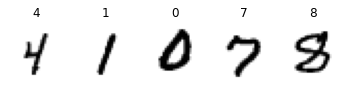

In [99]:
plt.figure(figsize=(6,3))
train_dataset = train_dataset.repeat(5).batch(32).prefetch(1)
for item in train_dataset:
    images = item["image"]
    labels = item["label"]
    for index in range(5):
        plt.subplot(1, 5, index + 1)
        image = images[index, ..., 0]
        label = labels[index].numpy()
        plt.imshow(image, cmap="binary")
        plt.title(label)
        plt.axis("off")
    break # just showing part of the first batch

In [101]:
datasets = tfds.load(name="mnist")
mnist_train, mnist_test = datasets["train"], datasets["test"]
mnist_train = mnist_train.repeat(5).batch(32)
mnist_train = mnist_train.map(lambda items: (items["image"], items["label"]))
mnist_train = mnist_train.prefetch(1)
for images, labels in mnist_train.take(1):
    print(images.shape)
    print(labels.numpy())

(32, 28, 28, 1)
[4 1 0 7 8 1 2 7 1 6 6 4 7 7 3 3 7 9 9 1 0 6 6 9 9 4 8 9 4 7 3 3]


In [102]:
datasets = tfds.load(name="mnist", batch_size=32, as_supervised=True)
mnist_train = datasets["train"].repeat().prefetch(1)
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28, 1]),
    keras.layers.Lambda(lambda images: tf.cast(images, tf.float32)),
    keras.layers.Dense(10, activation="softmax")])
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])
model.fit(mnist_train, steps_per_epoch=60000 // 32, epochs=5)

Epoch 1/5
1875/1875 [==============================] - 5s 3ms/step - loss: 32.2238 - accuracy: 0.8424
Epoch 2/5
1875/1875 [==============================] - 5s 3ms/step - loss: 26.0739 - accuracy: 0.8688
Epoch 3/5
1875/1875 [==============================] - 5s 2ms/step - loss: 24.9871 - accuracy: 0.8730
Epoch 4/5
1875/1875 [==============================] - 5s 2ms/step - loss: 24.0950 - accuracy: 0.8757
Epoch 5/5
1875/1875 [==============================] - 5s 2ms/step - loss: 24.3907 - accuracy: 0.8771


## TensorFlow Hub

In [103]:
import tensorflow_hub as hub

hub_layer = hub.KerasLayer("https://tfhub.dev/google/nnlm-en-dim50/2",
                           output_shape=[50], input_shape=[], dtype=tf.string)

model = keras.Sequential()
model.add(hub_layer)
model.add(keras.layers.Dense(16, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 50)                48190600  
_________________________________________________________________
dense_6 (Dense)              (None, 16)                816       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 17        
Total params: 48,191,433
Trainable params: 833
Non-trainable params: 48,190,600
_________________________________________________________________


In [104]:
sentences = tf.constant(["It was a great movie", "The actors were amazing"])
embeddings = hub_layer(sentences)

In [105]:
embeddings

<tf.Tensor: shape=(2, 50), dtype=float32, numpy=
array([[ 7.45939985e-02,  2.76720114e-02,  9.38646123e-02,
         1.25124469e-01,  5.40293928e-04, -1.09435350e-01,
         1.34755149e-01, -9.57818255e-02, -1.85177118e-01,
        -1.69703495e-02,  1.75612606e-02, -9.06603858e-02,
         1.12110220e-01,  1.04646273e-01,  3.87700424e-02,
        -7.71859884e-02, -3.12189370e-01,  6.99466765e-02,
        -4.88970093e-02, -2.99049795e-01,  1.31183028e-01,
        -2.12630898e-01,  6.96169436e-02,  1.63592950e-01,
         1.05169769e-02,  7.79720694e-02, -2.55230188e-01,
        -1.80790052e-01,  2.93739915e-01,  1.62875261e-02,
        -2.80566931e-01,  1.60284728e-01,  9.87277832e-03,
         8.44555616e-04,  8.39456245e-02,  3.24002892e-01,
         1.53253034e-01, -3.01048346e-02,  8.94618109e-02,
        -2.39153411e-02, -1.50188789e-01, -1.81733668e-02,
        -1.20483577e-01,  1.32937476e-01, -3.35325629e-01,
        -1.46504581e-01, -1.25251599e-02, -1.64428815e-01,
       

# End of Chapter Exercises

1. Why would you want to use the Data API?
2. What are the benefits of splitting a large dataset into multiple files?
3. During training, how can you tell that your input pipeline is the bottleneck?
   What can you do to fix it?
4. Can you save any binary data to a TFRecord file, or only serialized protocol
   buffers?
5. Why would you go through the hassle of converting all your data to the Example
   protobuf format? Why not use your own protobuf definition?
6. When using TFRecords, when would you want to activate compression? Why
   not do it systematically?
7. Data can be preprocessed directly when writing the data files, or within the
   tf.data pipeline, or in preprocessing layers within your model, or using TF Trans‐
   form. Can you list a few pros and cons of each option?
8. Name a few common techniques you can use to encode categorical features.
   What about text?
9. Load the Fashion MNIST dataset (introduced in Chapter 10); split it into a train‐
   ing set, a validation set, and a test set; shuffle the training set; and save each
   dataset to multiple TFRecord files. Each record should be a serialized Example
   protobuf with two features: the serialized image (use tf.io.serialize_tensor()
   to serialize each image), and the label.11 Then use tf.data to create an efficient
   dataset for each set. Finally, use a Keras model to train these datasets, including a
   preprocessing layer to standardize each input feature. Try to make the input
   pipeline as efficient as possible, using TensorBoard to visualize profiling data.
10. In this exercise you will download a dataset, split it, create a tf.data.Dataset to
    load it and preprocess it efficiently, then build and train a binary classification
    model containing an Embedding layer:
    
    
    a. Download the Large Movie Review Dataset, which contains 50,000 movies
    reviews from the Internet Movie Database. The data is organized in two direc‐
    tories, train and test, each containing a pos subdirectory with 12,500 positive
    reviews and a neg subdirectory with 12,500 negative reviews. Each review is
    stored in a separate text file. There are other files and folders (including pre‐
    processed bag-of-words), but we will ignore them in this exercise.
    
    b. Split the test set into a validation set (15,000) and a test set (10,000).
    
    c. Use tf.data to create an efficient dataset for each set.
    
    
    d. Create a binary classification model, using a TextVectorization layer to pre‐
    process each review. If the TextVectorization layer is not yet available (or if
    you like a challenge), try to create your own custom preprocessing layer: you
    can use the functions in the tf.strings package, for example lower() to
    make everything lowercase, regex_replace() to replace punctuation with
    spaces, and split() to split words on spaces. You should use a lookup table to
    output word indices, which must be prepared in the adapt() method.
    
    
    e. Add an Embedding layer and compute the mean embedding for each review,
    multiplied by the square root of the number of words (see Chapter 16). This
    rescaled mean embedding can then be passed to the rest of your model.
    
    
    f. Train the model and see what accuracy you get. Try to optimize your pipelines
    to make training as fast as possible.
    
    
    g. Use TFDS to load the same dataset more easily: tfds.load("imdb_reviews").

***1. Why would you want to use the Data API?***

A: If you are dealing with a very large dataset, it can be a huge processing challenge or even take a while. With the tools available in the Data API, it simplifies it so that you can can load various data sources, multiple sources of the data in parallel from several sources or folders and there are also easy ways to transform data, shuffle it, batch it and prefetch it.

***2. What are the benefits of splitting a large dataset into multiple files?***

A: The benefit here is that you can handle a large dataset that doesn't fit on a single machine. And you can load thousands of smaller files as opposed to one large one. Computationally, it is always faster to divide and conquer than to iterate through a massive dataset.

***3. During training, how can you tell that your input pipeline is the bottleneck?
   What can you do to fix it?***
   
A: In this scenario you could use TensorBoard to visualize your data. You will also be able to view your GPU Usage as well which is useful to look for bottlenecks. One possible fix is processing the data across multiple threads or multithreading in parallel to prefetch batches.

***4. Can you save any binary data to a TFRecord file, or only serialized protocol
   buffers?
   
A: From the chapter exercise we saw tha you can save any binary data into a TFRecord but most TFRecord files contain sequences of serialized protocol buffers already. Protocol Buffers make files easily readable across multiple platforms as they as structured similar to XML documents and files. 

***5. Why would you go through the hassle of converting all your data to the Example
   protobuf format? Why not use your own protobuf definition?***
   
A: The Example protobuf format has the advantage that TensorFlow provides some
operations to parse it (the tf.io.parse*example() functions) without you hav‐
ing to define your own format. If this doesn't work, you can define your own and the benefit would be if the Example protobuf doesn't cover your main use case.

***6. When using TFRecords, when would you want to activate compression? Why
   not do it systematically?***
   
A: When using TFRecords,compression becomes useful if the TFRecord files will need to be downloaded by the training script, as this will make the files smaller. But if the files are located on the same machine as the training script, it’s usually preferable to leave com‐
pression off, might not need to use CPU power in this case.

***7. Data can be preprocessed directly when writing the data files, or within the
   tf.data pipeline, or in preprocessing layers within your model, or using TF Transform. Can you list a few pros and cons of each option?***
   
A: 

Pros: 
- Training script will run faster when preprocessing data in data files split across several files
- If you build a TF Pipeline, you can then simply tweak the preprocessing informatoin and use data augmentation.
- TF Transofrm for preprocessing allows the preprocessed data to be materialized, and preprocessing layers get generated automatically. 

Cons:
- If you want to perform data augmentation, you have to fix many variants of your dataset, which will use a large amount of time to generate.
- Preprocessing is generally slower in a pipeline
- Preprocessing data generally takes longer to train data.

***8. Name a few common techniques you can use to encode categorical features.
   What about text?***
   
A: 
- Types of reviews (Terrible, Bad, Good, Great, etc.) where they are mapped to 1,2,3,4,etc. can use ordinal encoding where they are sorted in ascending or descending order and mapped accordingly.
- For text, you can use a bag-of-words techique with TF-IDF where the vector represents space between words and phrases. This could help with pairing words like how man is to woman as boy is to girl.

In [106]:
# Question #9
'''
9. Load the Fashion MNIST dataset (introduced in Chapter 10); split it into a train‐
   ing set, a validation set, and a test set; shuffle the training set; and save each
   dataset to multiple TFRecord files. Each record should be a serialized Example
   protobuf with two features: the serialized image (use tf.io.serialize_tensor()
   to serialize each image), and the label. Then use tf.data to create an efficient
   dataset for each set. Finally, use a Keras model to train these datasets, including a
   preprocessing layer to standardize each input feature. Try to make the input
   pipeline as efficient as possible, using TensorBoard to visualize profiling data.'''

import tensorflow as tf
import os
from tensorflow import keras

### Load the Fashion MNIST dataset (introduced in Chapter 10); split it into a training set, a validation set, and a test set; shuffle the training set; and save each dataset to multiple TFRecord files. Each record should be a serialized Example protobuf with two features: the serialized image (use tf.io.serialize_tensor() to serialize each image), and the label.

In [107]:
(X_train_ds, y_train_ds), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_val, X_train = X_train_ds[:5000], X_train_ds[5000:]
y_val, y_train = y_train_ds[:5000], y_train_ds[5000:]

In [108]:
training_set = tf.data.Dataset.from_tensor_slices((X_train, y_train))
training_set = training_set.shuffle(len(X_train))
validation_set = tf.data.Dataset.from_tensor_slices((X_val, y_val))
testing_set = tf.data.Dataset.from_tensor_slices((X_test, y_test))

Let us now create a function that will use our datasets and create a serialized Example protobuf. (Like in Question 5 and the previous sections of this chapter). We will use a serialized tensor for each and then we will want a labela dn details for our image in a list (specifically in bytes). So we will need to import these protobuf features from `tensorflow.train`. Let's try and build a function that can help with that now:

In [109]:
from tensorflow.train import BytesList, FloatList, Int64List
from tensorflow.train import Feature, Features, Example
BytesList = tf.train.BytesList
FloatList = tf.train.FloatList
Int64List = tf.train.Int64List
Feature = tf.train.Feature
Features = tf.train.Features
Example = tf.train.Example
def Ex_Protobuf(image_tens, label_tens):
    image = tf.io.serialize_tensor(image_tens)
    return Example(
        features=Features(
            feature={
                "image": Feature(bytes_list=BytesList(value=[image.numpy()])),
                "label": Feature(int64_list=Int64List(value=[label_tens])),
            }))

In [110]:
for images,labels in testing_set.take(3):
    print(Ex_Protobuf(images,labels))

features {
  feature {
    key: "image"
    value {
      bytes_list {
        value: "\010\004\022\010\022\002\010\034\022\002\010\034\"\220\006\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\00

In [111]:
def save_to_multiple_files(data, name_prefix, n_parts=10):
    paths = ["mytfrecord_{}_{:02d}-of-{:02d}".format(data, indx, n_parts) for indx in range(n_parts)]
    write_to_file = [tf.io.TFRecordWriter(path) for path in paths]
    for indx, (image, label) in name_prefix.enumerate():
        file_to_write = indx % n_parts
        ex = Ex_Protobuf(image, label)
        write_to_file[file_to_write].write(ex.SerializeToString())
    return paths

In [112]:
train_filepaths = save_to_multiple_files("my_fashion_mnist.train", training_set)
valid_filepaths = save_to_multiple_files("my_fashion_mnist.valid", validation_set)
test_filepaths = save_to_multiple_files("my_fashion_mnist.test", testing_set)

### Then use tf.data to create an efficient dataset for each set. Finally, use a Keras model to train these datasets, including a preprocessing layer to standardize each input feature. Try to make the input pipeline as efficient as possible, using TensorBoard to visualize profiling data.

In [113]:
def dataset(filepaths, threads=5, shuffle_size=None, threads_in_parallel=5, batch_size=32, cache=True):
    data_set = tf.data.TFRecordDataset(filepaths, num_parallel_reads=threads)
    
    if cache == True:
        data_set = data_set.cache()
    if shuffle_size == True:
        data_set = data_set.shuffle(shuffle_size)
    data_set = data_set.map(preprocess_data, num_parallel_calls=threads_in_parallel)
    data_set = data_set.batch(batch_size)
    return data_set.prefetch(1)

def preprocess_data(record):
    record_features = {
        "image": tf.io.FixedLenFeature([], tf.string, default_value=""),
        "label": tf.io.FixedLenFeature([], tf.int64, default_value=-1)
    }
    example = tf.io.parse_single_example(record, record_features)
    image = tf.io.parse_tensor(example["image"], out_type=tf.uint8)
    image = tf.reshape(image, shape=[28, 28])
    return image, example["label"]

In [114]:
train_set = dataset(train_filepaths, shuffle_size=60000)
valid_set = dataset(valid_filepaths)
test_set = dataset(test_filepaths)

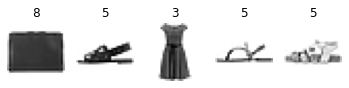

In [115]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
for X, y in train_set.take(1):
    for i in range(5):
        plt.subplot(1, 5, i + 1)
        plt.imshow(X[i].numpy(), cmap="binary")
        plt.axis("off")
        plt.title(str(y[i].numpy()))

In [116]:
import numpy as np
standardization = keras.layers.Normalization(input_shape=[28,28])

sample_image_batches = train_set.take(100).map(lambda image, label: image)
sample_images = np.concatenate(list(sample_image_batches.as_numpy_iterator()),
                               axis=0).astype(np.float32)
standardization.adapt(sample_images)

model = keras.models.Sequential([
    standardization,
    keras.layers.Flatten(),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="nadam", metrics=["accuracy"])

In [117]:
from datetime import datetime
logs = os.path.join(os.curdir, "my_logs",
                    "run_" + datetime.now().strftime("%Y%m%d_%H%M%S"))

tensorboard_cb = tf.keras.callbacks.TensorBoard(
    log_dir=logs, histogram_freq=1, profile_batch=10)

model.fit(train_set, epochs=10, validation_data=valid_set,
          callbacks=[tensorboard_cb])

Epoch 1/10
1719/1719 [==============================] - 14s 8ms/step - loss: 0.4430 - accuracy: 0.8404 - val_loss: 0.3558 - val_accuracy: 0.8706
Epoch 2/10
1719/1719 [==============================] - 14s 8ms/step - loss: 0.3310 - accuracy: 0.8800 - val_loss: 0.3373 - val_accuracy: 0.8796
Epoch 3/10
1719/1719 [==============================] - 13s 8ms/step - loss: 0.2913 - accuracy: 0.8945 - val_loss: 0.3327 - val_accuracy: 0.8844
Epoch 4/10
1719/1719 [==============================] - 14s 8ms/step - loss: 0.2650 - accuracy: 0.9031 - val_loss: 0.3330 - val_accuracy: 0.8874
Epoch 5/10
1719/1719 [==============================] - 15s 8ms/step - loss: 0.2440 - accuracy: 0.9106 - val_loss: 0.3411 - val_accuracy: 0.8850
Epoch 6/10
1719/1719 [==============================] - 14s 8ms/step - loss: 0.2264 - accuracy: 0.9179 - val_loss: 0.3545 - val_accuracy: 0.8870
Epoch 7/10
1719/1719 [==============================] - 14s 8ms/step - loss: 0.2106 - accuracy: 0.9240 - val_loss: 0.3538 - val_ac

In [125]:
%load_ext tensorboard
%tensorboard --logdir=./my_logs --port=6009

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [119]:
# Question #10
'''10. In this exercise you will download a dataset, split it, create a tf.data.Dataset to
    load it and preprocess it efficiently, then build and train a binary classification
    model containing an Embedding layer:
    
    
    a. Download the Large Movie Review Dataset, which contains 50,000 movies
    reviews from the Internet Movie Database. The data is organized in two direc‐
    tories, train and test, each containing a pos subdirectory with 12,500 positive
    reviews and a neg subdirectory with 12,500 negative reviews. Each review is
    stored in a separate text file. There are other files and folders (including pre‐
    processed bag-of-words), but we will ignore them in this exercise.
    
    b. Split the test set into a validation set (15,000) and a test set (10,000).
    
    c. Use tf.data to create an efficient dataset for each set.
    
    
    d. Create a binary classification model, using a TextVectorization layer to pre‐
    process each review. If the TextVectorization layer is not yet available (or if
    you like a challenge), try to create your own custom preprocessing layer: you
    can use the functions in the tf.strings package, for example lower() to
    make everything lowercase, regex_replace() to replace punctuation with
    spaces, and split() to split words on spaces. You should use a lookup table to
    output word indices, which must be prepared in the adapt() method.
    
    
    e. Add an Embedding layer and compute the mean embedding for each review,
    multiplied by the square root of the number of words (see Chapter 16). This
    rescaled mean embedding can then be passed to the rest of your model.
    
    
    f. Train the model and see what accuracy you get. Try to optimize your pipelines
    to make training as fast as possible.
    
    
    g. Use TFDS to load the same dataset more easily: tfds.load("imdb_reviews").'''



'10. In this exercise you will download a dataset, split it, create a tf.data.Dataset to\n    load it and preprocess it efficiently, then build and train a binary classification\n    model containing an Embedding layer:\n    \n    \n    a. Download the Large Movie Review Dataset, which contains 50,000 movies\n    reviews from the Internet Movie Database. The data is organized in two direc‐\n    tories, train and test, each containing a pos subdirectory with 12,500 positive\n    reviews and a neg subdirectory with 12,500 negative reviews. Each review is\n    stored in a separate text file. There are other files and folders (including pre‐\n    processed bag-of-words), but we will ignore them in this exercise.\n    \n    b. Split the test set into a validation set (15,000) and a test set (10,000).\n    \n    c. Use tf.data to create an efficient dataset for each set.\n    \n    \n    d. Create a binary classification model, using a TextVectorization layer to pre‐\n    process each review

### a. Download the Large Movie Review Dataset, which contains 50,000 movies     reviews from the Internet Movie Database. The data is organized in two directories, train and test, each containing a pos subdirectory with 12,500 positive reviews and a neg subdirectory with 12,500 negative reviews. Each review is stored in a separate text file. There are other files and folders (including preprocessed bag-of-words), but we will ignore them in this exercise.

In [120]:
from pathlib import Path

DOWNLOAD_ROOT = "http://ai.stanford.edu/~amaas/data/sentiment/"
FILENAME = "aclImdb_v1.tar.gz"
filepath = keras.utils.get_file(FILENAME, DOWNLOAD_ROOT + FILENAME, extract=True)
path = Path(filepath).parent / "aclImdb"
path

WindowsPath('C:/Users/User/.keras/datasets/aclImdb')

Let's take a look at the split datasets.

In [121]:
def dataset_paths(path):
    return [str(path) for path in path.glob("*.txt")]

train_pos = dataset_paths(path / "train" / "pos")
train_neg = dataset_paths(path / "train" / "neg")
test_valid_pos = dataset_paths(path / "test" / "pos")
test_valid_neg = dataset_paths(path / "test" / "neg")

len(train_pos), len(train_neg), len(test_valid_pos), len(test_valid_neg)

(12500, 12500, 12500, 12500)

### b. Split the test set into a validation set (15,000) and a test set (10,000).

In [122]:
np.random.shuffle(test_valid_pos)

test_pos = test_valid_pos[:5000]
test_neg = test_valid_neg[:5000]
valid_pos = test_valid_pos[5000:]
valid_neg = test_valid_neg[5000:]

### c. Use tf.data to create an efficient dataset for each set.

In [123]:
def imdb_dataset(filepaths_positive, filepaths_negative):
    reviews = []
    labels = []
    for filepaths, label in ((filepaths_negative, 0), (filepaths_positive, 1)):
        for filepath in filepaths:
            with open(filepath, encoding="utf8") as review_file:
                reviews.append(review_file.read())
            labels.append(label)
    return tf.data.Dataset.from_tensor_slices(
        (tf.constant(reviews), tf.constant(labels)))

In [124]:
for X, y in imdb_dataset(train_pos, train_neg).take(3):
    print(X)
    print(y)
    print()

tf.Tensor(b"Story of a man who has unnatural feelings for a pig. Starts out with a opening scene that is a terrific example of absurd comedy. A formal orchestra audience is turned into an insane, violent mob by the crazy chantings of it's singers. Unfortunately it stays absurd the WHOLE time with no general narrative eventually making it just too off putting. Even those from the era should be turned off. The cryptic dialogue would make Shakespeare seem easy to a third grader. On a technical level it's better than you might think with some good cinematography by future great Vilmos Zsigmond. Future stars Sally Kirkland and Frederic Forrest can be seen briefly.", shape=(), dtype=string)
tf.Tensor(0, shape=(), dtype=int32)

tf.Tensor(b"Airport '77 starts as a brand new luxury 747 plane is loaded up with valuable paintings & such belonging to rich businessman Philip Stevens (James Stewart) who is flying them & a bunch of VIP's to his estate in preparation of it being opened to the public a

### d. Create a binary classification model, using a TextVectorization layer to pre‐process each review. If the TextVectorization layer is not yet available (or if you like a challenge), try to create your own custom preprocessing layer: you can use the functions in the tf.strings package, for example lower() to make everything lowercase, regex_replace() to replace punctuation with spaces, and split() to split words on spaces. You should use a lookup table to output word indices, which must be prepared in the adapt() method.

First we need to clean up the text files and get rid of HTML and excess punctuation

In [126]:
def preprocessing(data, n_words=50):
    shape = tf.shape(data) * tf.constant([1, 0]) + tf.constant([0, n_words])
    Z = tf.strings.substr(data, 0, 300)
    Z = tf.strings.lower(Z)
    Z = tf.strings.regex_replace(Z, b"<br\\s*/?>", b" ")
    Z = tf.strings.regex_replace(Z, b"[^a-z]", b" ")
    Z = tf.strings.split(Z)
    return Z.to_tensor(shape=shape, default_value=b"<pad>")

X_example = tf.constant(["What the dog doin", "I wonder... hmmm!!!"])
preprocessing(X_example)   

<tf.Tensor: shape=(2, 50), dtype=string, numpy=
array([[b'what', b'the', b'dog', b'doin', b'<pad>', b'<pad>', b'<pad>',
        b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>',
        b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>',
        b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>',
        b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>',
        b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>',
        b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>',
        b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>',
        b'<pad>'],
       [b'i', b'wonder', b'hmmm', b'<pad>', b'<pad>', b'<pad>', b'<pad>',
        b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>',
        b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>',
        b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>',
        b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>',
        b'<pad>', b'<pad>', b'<pad>', b

Now let's write a second utility function that will take a data sample with the same format as the output of the `preprocess()` function, and will output the list of the top `max_size` most frequent words, ensuring that the padding token is first:

In [127]:
from collections import Counter

def get_vocabulary(data_sample, max_size=1000):
    preprocessed_reviews = preprocessing(data_sample).numpy()
    counter = Counter()
    for words in preprocessed_reviews:
        for word in words:
            if word != b"<pad>":
                counter[word] += 1
    return [b"<pad>"] + [word for word, count in counter.most_common(max_size)]

get_vocabulary(X_example)

[b'<pad>', b'what', b'the', b'dog', b'doin', b'i', b'wonder', b'hmmm']

In [128]:
# Custom class for TextVectorization

class TextVectorization(keras.layers.Layer):
    def __init__(self, max_vocabulary_size=1000, n_oov_buckets=100, dtype=tf.string, **kwargs):
        super().__init__(dtype=dtype, **kwargs)
        self.max_vocabulary_size = max_vocabulary_size
        self.n_oov_buckets = n_oov_buckets

    def adapt(self, data_sample):
        self.vocab = get_vocabulary(data_sample, self.max_vocabulary_size)
        words = tf.constant(self.vocab)
        word_ids = tf.range(len(self.vocab), dtype=tf.int64)
        vocab_init = tf.lookup.KeyValueTensorInitializer(words, word_ids)
        self.table = tf.lookup.StaticVocabularyTable(vocab_init, self.n_oov_buckets)
        
    def call(self, inputs):
        preprocessed_inputs = preprocessing(inputs)
        return self.table.lookup(preprocessed_inputs)

In [129]:
#Test

text_vectorization = TextVectorization()

text_vectorization.adapt(X_example)
text_vectorization(X_example)

<tf.Tensor: shape=(2, 50), dtype=int64, numpy=
array([[1, 2, 3, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0],
       [5, 6, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0]], dtype=int64)>

In [130]:
# Now for our main dataset

def imdb_dataset(filepaths_positive, filepaths_negative, n_read_threads=5):
    dataset_neg = tf.data.TextLineDataset(filepaths_negative,
                                          num_parallel_reads=n_read_threads)
    dataset_neg = dataset_neg.map(lambda review: (review, 0))
    dataset_pos = tf.data.TextLineDataset(filepaths_positive,
                                          num_parallel_reads=n_read_threads)
    dataset_pos = dataset_pos.map(lambda review: (review, 1))
    return tf.data.Dataset.concatenate(dataset_pos, dataset_neg)

batch_size = 32

train_set = imdb_dataset(train_pos, train_neg).shuffle(25000).batch(batch_size).prefetch(1)
valid_set = imdb_dataset(valid_pos, valid_neg).batch(batch_size).prefetch(1)
test_set = imdb_dataset(test_pos, test_neg).batch(batch_size).prefetch(1)

In [131]:
max_vocabulary_size = 1000
n_oov_buckets = 100

sample_review_batches = train_set.map(lambda review, label: review)
sample_reviews = np.concatenate(list(sample_review_batches.as_numpy_iterator()),
                                axis=0)

text_vectorization = TextVectorization(max_vocabulary_size, n_oov_buckets,
                                       input_shape=[])
text_vectorization.adapt(sample_reviews)

In [132]:
text_vectorization(X_example)

<tf.Tensor: shape=(2, 50), dtype=int64, numpy=
array([[  43,    1,  909, 1086,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0],
       [   5,  657, 1032,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0]], dtype=int64)>

In [133]:
text_vectorization.vocab[:10] # first 10 words in vocabulary 

[b'<pad>', b'the', b'a', b'of', b'and', b'i', b'to', b'is', b'this', b'it']

In [134]:
simple_example = tf.constant([[1, 3, 1, 0, 0], [2, 2, 0, 0, 0]])
tf.reduce_sum(tf.one_hot(simple_example, 4), axis=1)

<tf.Tensor: shape=(2, 4), dtype=float32, numpy=
array([[2., 2., 0., 1.],
       [3., 0., 2., 0.]], dtype=float32)>

The first review has 2 times the word 0, 2 times the word 1, 0 times the word 2, and 1 time the word 3, so its bag-of-words representation is [2, 2, 0, 1]. Similarly, the second review has 3 times the word 0, 0 times the word 1, and so on. Let's wrap this logic in a small custom layer, and let's test it. We'll drop the counts for the word 0, since this corresponds to the <pad> token, which we don't care about.

In [135]:
# Bag of words class
class BagOfWords(keras.layers.Layer):
    def __init__(self, n_tokens, dtype=tf.int32, **kwargs):
        super().__init__(dtype=dtype, **kwargs)
        self.n_tokens = n_tokens
    def call(self, inputs):
        one_hot = tf.one_hot(inputs, self.n_tokens)
        return tf.reduce_sum(one_hot, axis=1)[:, 1:]

In [136]:
bag_of_words = BagOfWords(n_tokens=4)
bag_of_words(simple_example)

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[2., 0., 1.],
       [0., 2., 0.]], dtype=float32)>

In [137]:
n_tokens = max_vocabulary_size + n_oov_buckets + 1 # add 1 for <pad>
bag_of_words = BagOfWords(n_tokens)

In [138]:
model = keras.models.Sequential([
    text_vectorization,
    bag_of_words,
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(1, activation="sigmoid"),
])
model.compile(loss="binary_crossentropy", optimizer="nadam",
              metrics=["accuracy"])
model.fit(train_set, epochs=5, validation_data=valid_set)

Epoch 1/5
782/782 [==============================] - 22s 26ms/step - loss: 0.5426 - accuracy: 0.7174 - val_loss: 0.5119 - val_accuracy: 0.7418
Epoch 2/5
782/782 [==============================] - 10s 12ms/step - loss: 0.4705 - accuracy: 0.7705 - val_loss: 0.5104 - val_accuracy: 0.7409
Epoch 3/5
782/782 [==============================] - 9s 11ms/step - loss: 0.4184 - accuracy: 0.8043 - val_loss: 0.5229 - val_accuracy: 0.7378
Epoch 4/5
782/782 [==============================] - 9s 11ms/step - loss: 0.3500 - accuracy: 0.8516 - val_loss: 0.5405 - val_accuracy: 0.7378
Epoch 5/5
782/782 [==============================] - 8s 9ms/step - loss: 0.2685 - accuracy: 0.9002 - val_loss: 0.5752 - val_accuracy: 0.7329


### e. Add an Embedding layer and compute the mean embedding for each review,    multiplied by the square root of the number of words (see Chapter 16). This rescaled mean embedding can then be passed to the rest of your model.

To compute the mean embedding for each review, and multiply it by the square root of the number of words in that review, we will need a little function. For each sentence, this function needs to compute $M \times \sqrt N$, where $M$ is the mean of all the word embeddings in the sentence (excluding padding tokens), and $N$ is the number of words in the sentence (also excluding padding tokens). We can rewrite $M$ as $\dfrac{S}{N}$, where $S$ is the sum of all word embeddings (it does not matter whether or not we include the padding tokens in this sum, since their representation is a zero vector). So the function must return $M \times \sqrt N = \dfrac{S}{N} \times \sqrt N = \dfrac{S}{\sqrt N \times \sqrt N} \times \sqrt N= \dfrac{S}{\sqrt N}$.

In [139]:
def compute_mean_embedding(inputs):
    not_pad = tf.math.count_nonzero(inputs, axis=-1)
    n_words = tf.math.count_nonzero(not_pad, axis=-1, keepdims=True)    
    sqrt_n_words = tf.math.sqrt(tf.cast(n_words, tf.float32))
    return tf.reduce_sum(inputs, axis=1) / sqrt_n_words

another_example = tf.constant([[[1., 2., 3.], [4., 5., 0.], [0., 0., 0.]],
                               [[6., 0., 0.], [0., 0., 0.], [0., 0., 0.]]])
compute_mean_embedding(another_example)

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[3.535534 , 4.9497476, 2.1213205],
       [6.       , 0.       , 0.       ]], dtype=float32)>

Let's check that this is correct. The first review contains 2 words (the last token is a zero vector, which represents the <pad> token). Let's compute the mean embedding for these 2 words, and multiply the result by the square root of 2:

In [140]:
tf.reduce_mean(another_example[0:1, :2], axis=1) * tf.sqrt(2.)

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[3.535534 , 4.9497476, 2.1213202]], dtype=float32)>

Looks good! Now let's check the second review, which contains just one word (we ignore the two padding tokens):

In [141]:
tf.reduce_mean(another_example[1:2, :1], axis=1) * tf.sqrt(1.)

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[6., 0., 0.]], dtype=float32)>

Now for the model:

In [142]:
embedding_size = 20

model = keras.models.Sequential([
    text_vectorization,
    keras.layers.Embedding(input_dim=n_tokens,
                           output_dim=embedding_size,
                           mask_zero=True), # <pad> tokens => zero vectors
    keras.layers.Lambda(compute_mean_embedding),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(1, activation="sigmoid"),
])

### F. Train the model and see what accuracy you get. Try to optimize your pipelines to make training as fast as possible.

In [143]:
model.compile(loss="binary_crossentropy", optimizer="nadam", metrics=["accuracy"])
model.fit(train_set, epochs=5, validation_data=valid_set)

Epoch 1/5
782/782 [==============================] - 11s 12ms/step - loss: 0.5545 - accuracy: 0.7066 - val_loss: 0.5265 - val_accuracy: 0.7272
Epoch 2/5
782/782 [==============================] - 12s 14ms/step - loss: 0.4945 - accuracy: 0.7565 - val_loss: 0.5108 - val_accuracy: 0.7429
Epoch 3/5
782/782 [==============================] - 10s 11ms/step - loss: 0.4835 - accuracy: 0.7594 - val_loss: 0.5136 - val_accuracy: 0.7383
Epoch 4/5
782/782 [==============================] - 13s 15ms/step - loss: 0.4753 - accuracy: 0.7628 - val_loss: 0.5168 - val_accuracy: 0.7363
Epoch 5/5
782/782 [==============================] - 13s 15ms/step - loss: 0.4693 - accuracy: 0.7652 - val_loss: 0.5096 - val_accuracy: 0.7429


### G. Exercise: Use TFDS to load the same dataset more easily: tfds.load("imdb_reviews").

In [144]:
import tensorflow_datasets as tfds

datasets = tfds.load(name="imdb_reviews")
train_set, test_set = datasets["train"], datasets["test"]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling imdb_reviews-train.tfrecord...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling imdb_reviews-test.tfrecord...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised examples...: 0 examples [00:00, ? examples/s]

Shuffling imdb_reviews-unsupervised.tfrecord...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset imdb_reviews downloaded and prepared to C:\Users\User\tensorflow_datasets\imdb_reviews\plain_text\1.0.0. Subsequent calls will reuse this data.


In [145]:
for example in train_set.take(1):
    print(example["text"])
    print(example["label"])

tf.Tensor(b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.", shape=(), dtype=string)
tf.Tensor(0, shape=(), dtype=int64)
